In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data

In [2]:
#btc options data
df=pd.read_csv('data/btc_data.csv', sep=",", index_col=0)

#df.drop(columns=['Unnamed: 0', 'interest_rate'], inplace=True)


In [3]:
# Convert date column
df['Expiration_Date'] = pd.to_datetime(df['Expiration Date'], format='%d%b%y')

### Black-Scholes model

* Stock Price (S): In cryptocurrency, this would be the current price of the crypto asset.

* Strike Price (K): The price at which the option can be exercised.

* Time to Expiration (T): The remaining life of the option, usually in years.

* Risk-free Rate (r): The rate of return on a risk-free investment, typically treasury bills.

* Volatility (σ): This is where most adjustments for cryptocurrencies will be made, reflecting the asset's price variability.

example

In [4]:
import numpy as np
from scipy.stats import norm

# Parameters
S = 59330.12  # current BTC price
K = 35000     # strike price
T = 0.25      # time to maturity in years
r = 0.01      # risk-free rate
sigma = 1.20  # adjusted annual volatility

# Black-Scholes formulas
d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

print(f"The adjusted Black-Scholes call price is: ${call_price:.2f}")


The adjusted Black-Scholes call price is: $27166.22


In [5]:
import numpy as np
from scipy.stats import norm
from datetime import datetime

# Assuming you've loaded your dataset into a DataFrame named `df`
# For this example, let's select one option to price, e.g., the first row in the dataset
option_data = df.iloc[20]

# Parameters extraction
S = option_data['underlying_price']  # Current price of the underlying asset
K = option_data['Strike Price']      # Strike price of the option
# Adjust the date format to match '3MAY24' which is 'd%b%y' without day leading zero and all-caps month
T = (datetime.strptime(option_data['Expiration Date'], '%d%b%y') - datetime.now()).days / 365.25  # Time to maturity in years
r = 0.01  # Assuming a risk-free rate of 1%
sigma = option_data['mark_iv'] / 100  # Implied volatility from the market data

# Adjusting volatility for crypto-specific factors
sigma *= 1.5  # Adjusting by 50% to account for higher volatility

# Black-Scholes formula for call option
d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

print(f"The adjusted Black-Scholes call price for the selected option is: ${call_price:.2f}")


The adjusted Black-Scholes call price for the selected option is: $nan


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\3153892223.py:21: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\3153892223.py:22: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


In [6]:
# Convert Expiration Date to datetime and calculate Time to Expiration in years
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])
df['Time to Expiration'] = (df['Expiration Date'] - pd.Timestamp.now()).dt.days / 365

# Use average implied volatility or calculate it if not directly provided
df['Implied Volatility'] = (df['bid_iv'] + df['ask_iv']) / 2 / 100  # converting percentage to decimal


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\434982000.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])


In [7]:
# Example: Using a simple moving average for volatility
df['SMA Volatility'] = df['Implied Volatility'].rolling(window=30).mean()  # 30-day simple moving average


In [8]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    """ Calculate the Black-Scholes option price for a call option """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Risk-free rate - As crypto does not have a clear risk-free rate, you may use a proxy like U.S. Treasury rates or a stablecoin yield
risk_free_rate = 0.02  # 2%


In [9]:
# Apply the model to each option in the dataframe
df['BS Price'] = df.apply(lambda x: black_scholes_call(x['underlying_price'], x['Strike Price'], x['Time to Expiration'], risk_free_rate, x['Implied Volatility']), axis=1)


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:5: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:6: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [10]:
# Apply the model to each option in the dataframe
df['BS Price_1'] = df.apply(lambda x: black_scholes_call(x['underlying_price'], x['Strike Price'], x['Time to Expiration'], risk_free_rate, x['SMA Volatility']), axis=1)


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:5: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:6: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


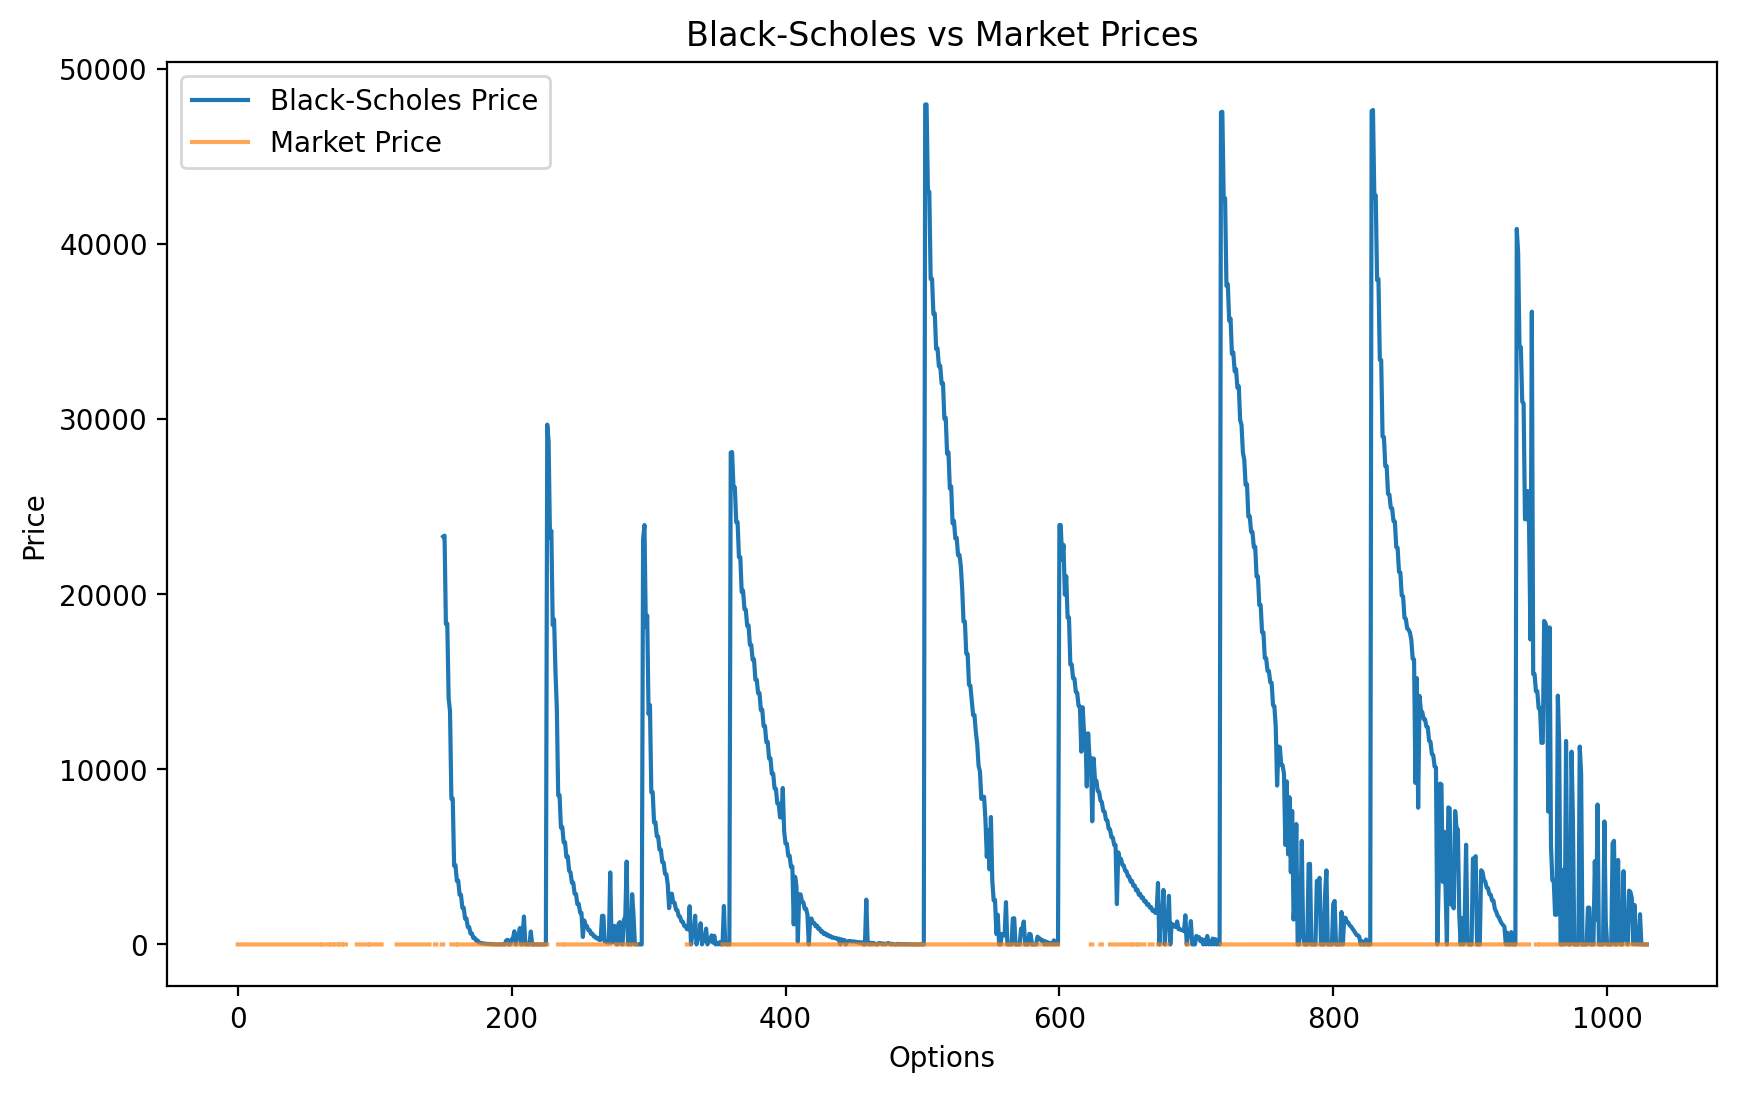

In [11]:
# Assume 'last_price' is the market price of the option
df['Market Price'] = df['last_price']  # or whatever the actual market price field is

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['BS Price'], label='Black-Scholes Price')
plt.plot(df['Market Price'], label='Market Price', alpha=0.7)
plt.title('Black-Scholes vs Market Prices')
plt.xlabel('Options')
plt.ylabel('Price')
plt.legend()
plt.show()


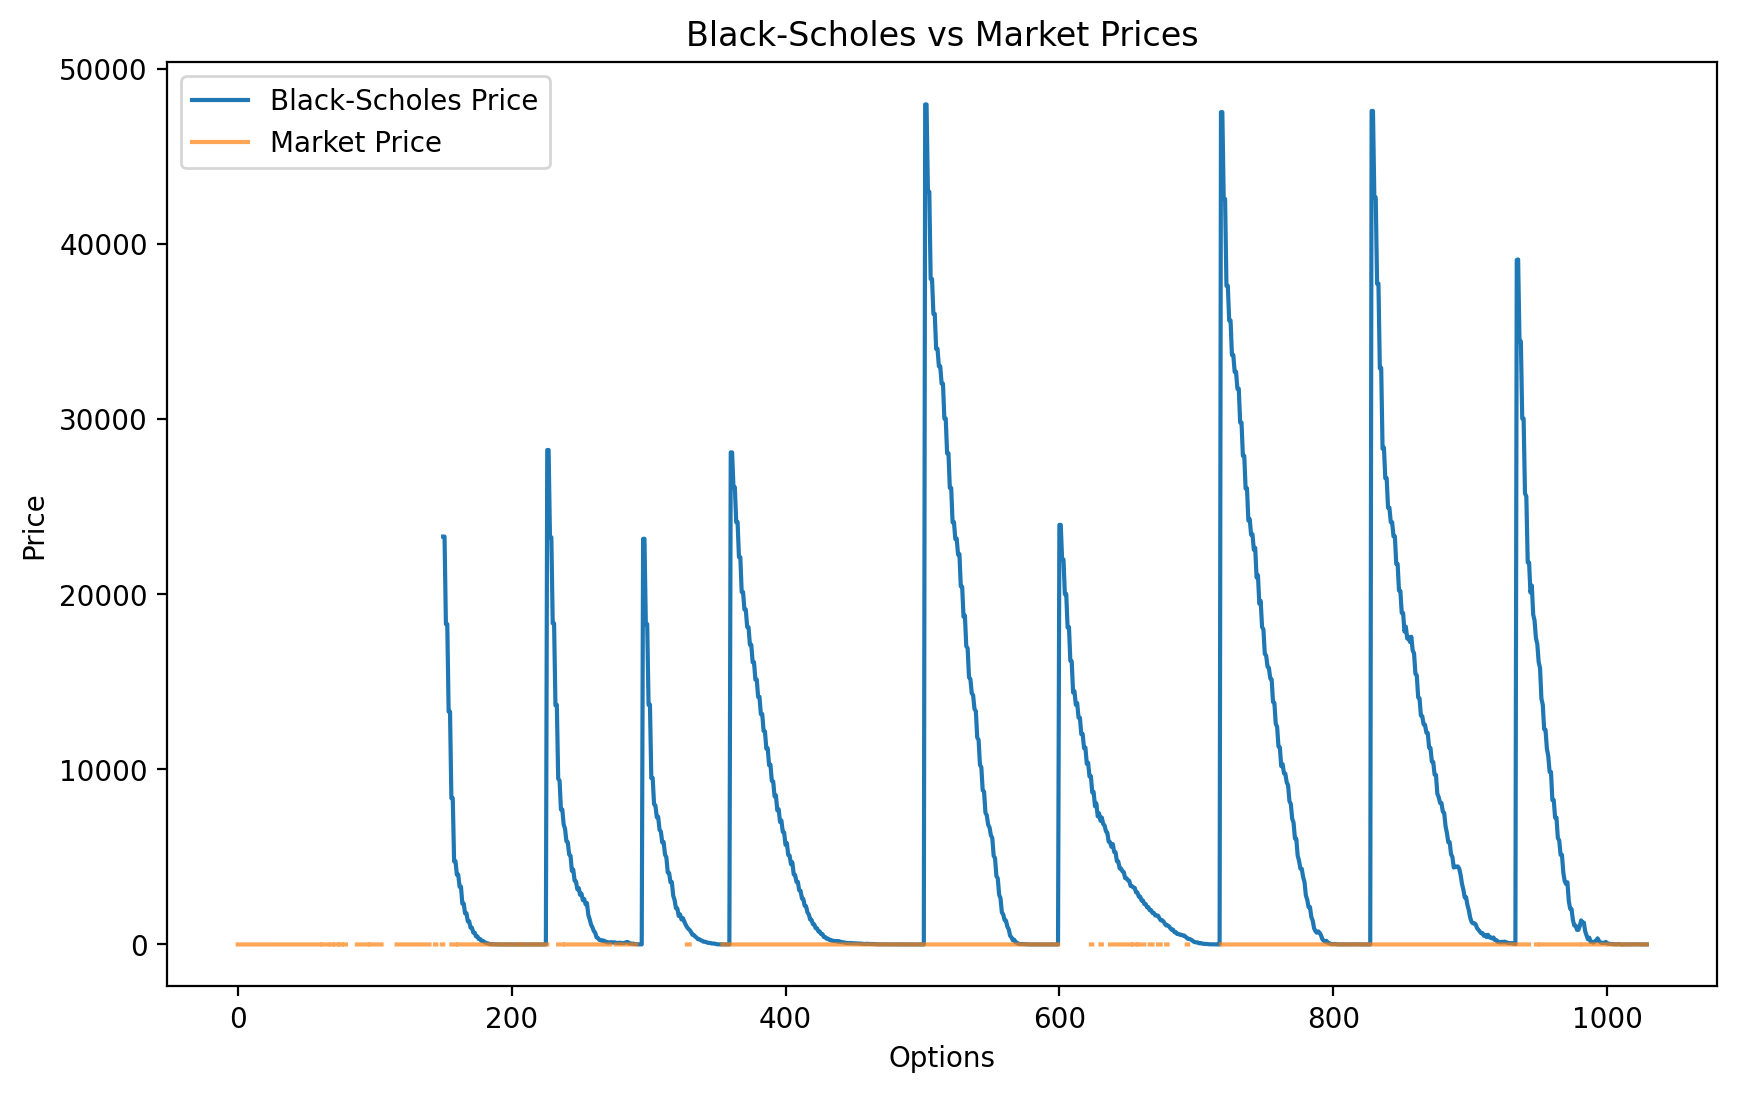

In [12]:
# Assume 'last_price' is the market price of the option
df['Market Price'] = df['last_price']  # or whatever the actual market price field is

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['BS Price_1'], label='Black-Scholes Price')
plt.plot(df['Market Price'], label='Market Price', alpha=0.7)
plt.title('Black-Scholes vs Market Prices')
plt.xlabel('Options')
plt.ylabel('Price')
plt.legend()
plt.show()


In [13]:
# Example: Calibrating volatility
from scipy.optimize import minimize

def mse(x, market_prices, S, K, T, r):
    sigma = x
    estimated_prices = [black_scholes_call(s, k, t, r, sigma) for s, k, t in zip(S, K, T)]
    return ((market_prices - estimated_prices) ** 2).mean()

initial_guess = 0.5
result = minimize(mse, initial_guess, args=(df['Market Price'].values, df['underlying_price'].values, df['Strike Price'].values, df['Time to Expiration'].values, risk_free_rate))
optimal_sigma = result.x


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:5: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:6: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


In [14]:
from scipy.optimize import minimize

# Define the Black-Scholes call pricing function
from scipy.stats import norm
import numpy as np

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Function to calculate mean squared error between theoretical and market prices
def mse(sigma, market_prices, S, K, T, r):
    estimated_prices = [black_scholes_call(s, k, t, r, sigma) for s, k, t in zip(S, K, T)]
    return np.mean((np.array(market_prices) - np.array(estimated_prices)) ** 2)

# Example data preparation: Assume df contains the relevant data
market_prices = df['Market Price'].values
underlying_prices = df['underlying_price'].values
strike_prices = df['Strike Price'].values
times_to_expiration = df['Time to Expiration'].values
risk_free_rate = 0.02  # Example rate, adjust according to your needs

# Optimize for the best sigma (volatility) using minimize
initial_guess = 0.5  # Initial guess for volatility
result = minimize(mse, initial_guess, args=(market_prices, underlying_prices, strike_prices, times_to_expiration, risk_free_rate))
optimal_sigma = result.x[0]

print(f"The optimal volatility (sigma) is: {optimal_sigma}")


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\2683938550.py:8: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\2683938550.py:9: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


The optimal volatility (sigma) is: 0.5


In [15]:
from scipy.stats import norm
import numpy as np
# Assuming you have already obtained the optimal volatility
sigma = 0.5  # Extract the optimal volatility value



# Define a safe version of the Black-Scholes Call pricing function
def black_scholes_call_safe(S, K, T, r, sigma):
    # Ensure parameters are within valid ranges
    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        return np.nan  # Return NaN if any parameter is invalid
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)



In [16]:
# Check for missing or zero values in relevant columns
print(df[['underlying_price', 'Strike Price', 'Time to Expiration']].isnull().sum())
print(df[['underlying_price', 'Strike Price', 'Time to Expiration']].min())


underlying_price      0
Strike Price          0
Time to Expiration    0
dtype: int64
underlying_price      57432.360000
Strike Price          10000.000000
Time to Expiration       -0.008219
dtype: float64


##### Filter out rows with zero or negative values in critical columns
##### Drop rows where Market Price is Null

In [17]:
# Filter out rows with zero or negative values in critical columns
df_clean = df[(df['underlying_price'] > 0) & (df['Strike Price'] > 0) & (df['Time to Expiration'] > 0)]

# Drop rows where Market Price is NaN to ensure the comparison is valid
# Alternatively, fill missing market prices with a default value or impute them
df_clean['Market Price'].fillna(df_clean['Market Price'].median(), inplace=True)
df_clean = df_clean.dropna(subset=['Market Price'])


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\2398533704.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Market Price'].fillna(df_clean['Market Price'].median(), inplace=True)


#### Apply Black-Scholes function 

In [18]:
# Apply the safe Black-Scholes function to the cleaned DataFrame
df_clean['Theoretical Price'] = df_clean.apply(lambda x: black_scholes_call_safe(x['underlying_price'], x['Strike Price'], x['Time to Expiration'], risk_free_rate, optimal_sigma), axis=1)

# Check the results for the cleaned data
print(df_clean[['Market Price', 'Theoretical Price']].head())


     Market Price  Theoretical Price
150       0.30450       23296.450392
151       0.10775       23296.450392
152       0.31000       18297.136163
153       0.10775       18297.136163
154       0.10775       13298.232123


### QuantLib

In [19]:
import QuantLib as ql


In [20]:
df_clean

,best_bid_amount,best_ask_amount,bid_iv,ask_iv,underlying_index,underlying_price,mark_iv,best_bid_price,best_ask_price,open_interest,...,Expiration Date,Strike Price,Expiration_Date,Time to Expiration,Implied Volatility,SMA Volatility,BS Price,BS Price_1,Market Price,Theoretical Price
150,0.0,0.0,0.0,0.00,BTC-10MAY24,58288.78,100.00,0.000,0.0000,0.0,...,2024-05-10,35000,2024-05-10,0.010959,0.00000,0.629460,23296.450392,23296.450392,0.30450,23296.450392
151,0.0,10.0,0.0,446.19,BTC-10MAY24,58288.78,100.00,0.000,0.0555,0.0,...,2024-05-10,35000,2024-05-10,0.010959,2.23095,0.682412,23349.956316,23296.450392,0.10775,23296.450392
152,0.0,0.0,0.0,0.00,BTC-10MAY24,58288.37,93.59,0.000,0.0000,0.0,...,2024-05-10,40000,2024-05-10,0.010959,0.00000,0.665380,18297.136163,18297.136181,0.31000,18297.136163
153,0.0,10.0,0.0,316.21,BTC-10MAY24,58288.37,93.59,0.000,0.0410,0.0,...,2024-05-10,40000,2024-05-10,0.010959,1.58105,0.698930,18328.411333,18297.136247,0.10775,18297.136163
154,0.0,10.0,0.0,438.46,BTC-10MAY24,58288.37,90.21,0.000,0.3465,0.0,...,2024-05-10,45000,2024-05-10,0.010959,2.19230,0.756555,14057.181873,13298.810442,0.10775,13298.232123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,0.0,0.0,0.0,0.00,BTC-28MAR25,58623.87,72.91,0.000,0.0000,162.5,...,2025-03-28,180000,2025-03-28,0.893151,0.00000,0.334265,0.000000,1.900505,1.54550,154.752649
1026,0.0,0.0,0.0,0.00,BTC-28MAR25,58623.87,74.71,0.000,0.0000,0.0,...,2025-03-28,190000,2025-03-28,0.893151,0.00000,0.334265,0.000000,0.976147,0.02450,112.667840
1027,100.0,0.0,0.0,0.00,BTC-28MAR25,58626.29,74.71,0.005,0.0000,0.0,...,2025-03-28,190000,2025-03-28,0.893151,0.00000,0.334265,0.000000,0.976694,2.19110,112.700273
1028,0.0,0.0,0.0,0.00,BTC-28MAR25,58626.29,75.47,0.000,0.0000,44.5,...,2025-03-28,200000,2025-03-28,0.893151,0.00000,0.311758,0.000000,0.140169,0.07600,82.546108


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1029 entries, 0 to 1029
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   best_bid_amount     1029 non-null   float64       
 1   best_ask_amount     1029 non-null   float64       
 2   bid_iv              1029 non-null   float64       
 3   ask_iv              1029 non-null   float64       
 4   underlying_index    1029 non-null   object        
 5   underlying_price    1029 non-null   float64       
 6   mark_iv             1029 non-null   float64       
 7   best_bid_price      1029 non-null   float64       
 8   best_ask_price      1029 non-null   float64       
 9   open_interest       1029 non-null   float64       
 10  max_price           1029 non-null   float64       
 11  min_price           1029 non-null   float64       
 12  last_price          864 non-null    float64       
 13  asks                1029 non-null   object        
 1

In [22]:
df = df_clean 

In [23]:
# Calculation date (today's date)
calculation_date = ql.Date(5, 5, 2024)
ql.Settings.instance().evaluationDate = calculation_date

# Market environment setup (replace with the actual values)
risk_free_rate = 0.02  # Example risk-free rate
rate_handle = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, ql.Actual365Fixed()))

# Function to infer option type from the instrument name
def infer_option_type(instrument_name):
    return ql.Option.Call if instrument_name.endswith('-C') else ql.Option.Put

# Function to price each option using QuantLib, inferring the option type
def quantlib_price_option(row):
    # Extract relevant data
    S = row['underlying_price']
    K = row['Strike Price']
    T_expiration = row['Expiration Date']
    implied_vol = row['Implied Volatility']
    option_type = infer_option_type(row['instrument_name'])

    # Set up the exercise date and payoff
    maturity_date = ql.Date(T_expiration.day, T_expiration.month, T_expiration.year)
    payoff = ql.PlainVanillaPayoff(option_type, K)
    exercise = ql.EuropeanExercise(maturity_date)

    # Spot price and volatility setup
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(S))
    volatility_handle = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, ql.NullCalendar(), implied_vol, ql.Actual365Fixed()))

    # Black-Scholes-Merton process
    bsm_process = ql.BlackScholesProcess(spot_handle, rate_handle, volatility_handle)

    # Set up the pricing engine using the BSM process
    pricing_engine = ql.AnalyticEuropeanEngine(bsm_process)

    # Create and price the European option
    european_option = ql.VanillaOption(payoff, exercise)
    european_option.setPricingEngine(pricing_engine)

    # Return the theoretical price
    return european_option.NPV()

# Apply the pricing function across the DataFrame
df['BS Price QuantLib'] = df.apply(quantlib_price_option, axis=1)

In [24]:
df[['underlying_price', 'Strike Price', 'Expiration Date', 'instrument_name', 'BS Price QuantLib']]


,underlying_price,Strike Price,Expiration Date,instrument_name,BS Price QuantLib
150,58288.78,35000,2024-05-10,BTC-10MAY24-35000-C,23298.367728
151,58288.78,35000,2024-05-10,BTC-10MAY24-35000-P,112.271170
152,58288.37,40000,2024-05-10,BTC-10MAY24-40000-C,18299.327403
153,58288.37,40000,2024-05-10,BTC-10MAY24-40000-P,68.571913
154,58288.37,45000,2024-05-10,BTC-10MAY24-45000-C,14370.238612
...,...,...,...,...,...
1025,58623.87,180000,2025-03-28,BTC-28MAR25-180000-P,118179.647023
1026,58623.87,190000,2025-03-28,BTC-28MAR25-190000-C,0.000000
1027,58626.29,190000,2025-03-28,BTC-28MAR25-190000-P,127999.644636
1028,58626.29,200000,2025-03-28,BTC-28MAR25-200000-C,0.000000


In [27]:
import numpy as np

# Example: Simulate a range of future prices
simulated_prices = np.linspace(45000, 70000, 10)  # Example BTC prices between 45k and 70k
strike_price = 50000
risk_free_rate = 0.02
time_to_expiration = 30 / 365  # 30 days to expiration
volatility = 0.25

# Function to calculate put and call prices using Black-Scholes model
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Calculate simulated call and put prices
simulated_call_prices = [black_scholes_call(price, strike_price, time_to_expiration, risk_free_rate, volatility) for price in simulated_prices]
simulated_put_prices = [black_scholes_put(price, strike_price, time_to_expiration, risk_free_rate, volatility) for price in simulated_prices]

# Print the simulated results
for price, call, put in zip(simulated_prices, simulated_call_prices, simulated_put_prices):
    print(f"Price: {price}, Call: {call}, Put: {put}")


Price: 45000.0, Call: 112.14272985298476, Put: 5030.018466918242
Price: 47777.77777777778, Call: 579.3512046797714, Put: 2719.4491639672488
Price: 50555.555555555555, Call: 1777.420403700282, Put: 1139.7405852099837
Price: 53333.333333333336, Call: 3771.065543942088, Put: 355.60794767401785
Price: 56111.11111111111, Call: 6274.959683006149, Put: 81.72430896030573
Price: 58888.88888888889, Call: 8984.988927491999, Put: 13.97577566837549
Price: 61666.66666666667, Call: 11750.607356542227, Put: 1.8164269408150204
Price: 64444.444444444445, Call: 14526.752741999233, Put: 0.18403462004989812
Price: 67222.22222222222, Call: 17304.36140289223, Put: 0.01491773527094209
Price: 70000.0, Call: 20082.125254666105, Put: 0.0009917313726240384
